<a href="https://colab.research.google.com/github/Bookas1468/data-science-google-colab/blob/main/exercises/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h2_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu =300, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd',nu =300, sigma = 10)
    #μ_nu=pm.StudentT('μ_nu', nu =300, mu = 0, sigma = 10)
    μ_nu= pm.HalfStudentT('μ_nu',nu =300, sigma = 10)
    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ', nu =μ_nu,
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu =300, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y', nu =300,
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h2 = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

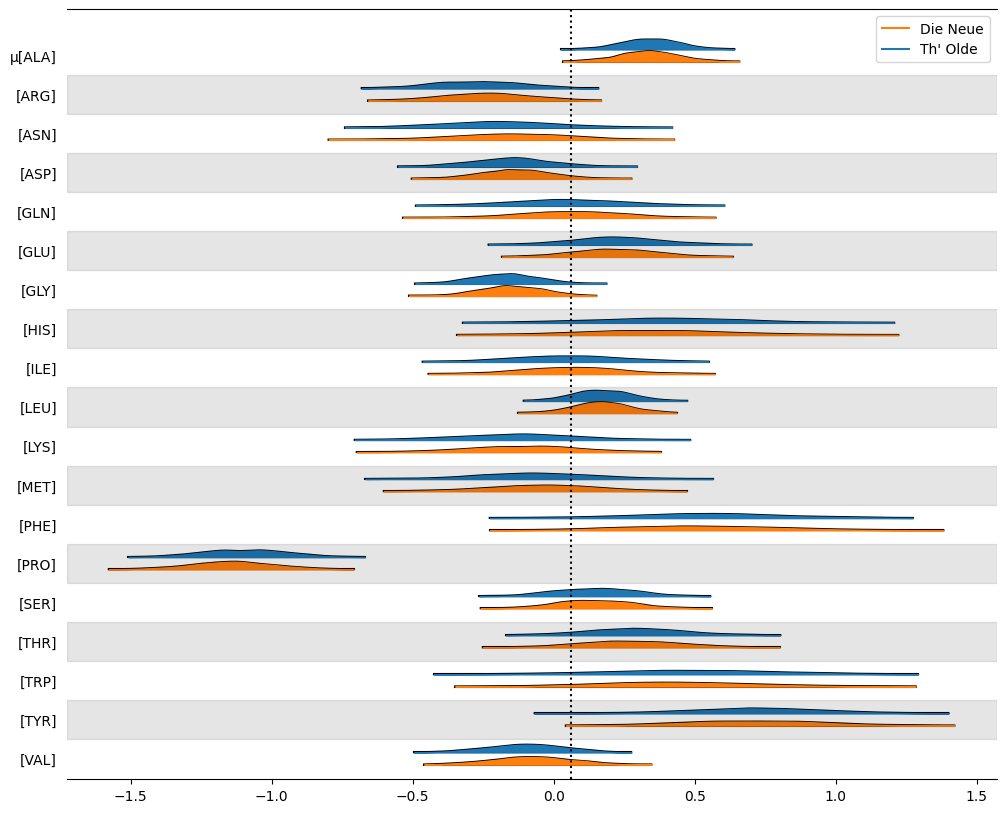

In [5]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_h, idata_cs_h2], kind="ridgeplot",
                      model_names=['Th\' Olde', 'Die Neue'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h2, model=cs_h2_model, extend_inferencedata=True)

<Axes: xlabel='y'>

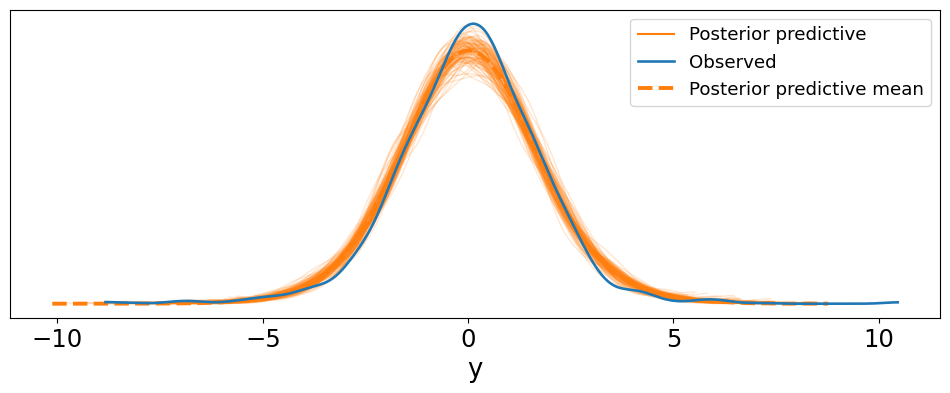

In [7]:
az.plot_ppc(idata_cs_h2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

<Axes: xlabel='y'>

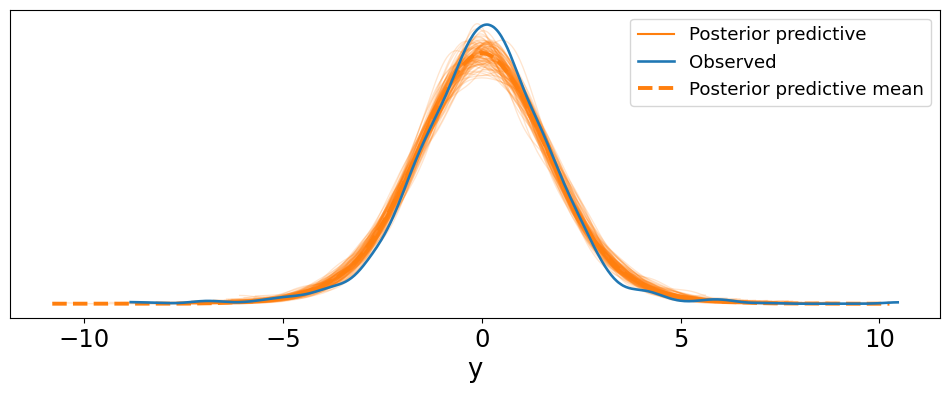

In [9]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

i think the StudentT is better because it has slightly less gap between the observed and predictive value.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data

In [11]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = .1, nu = 10, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

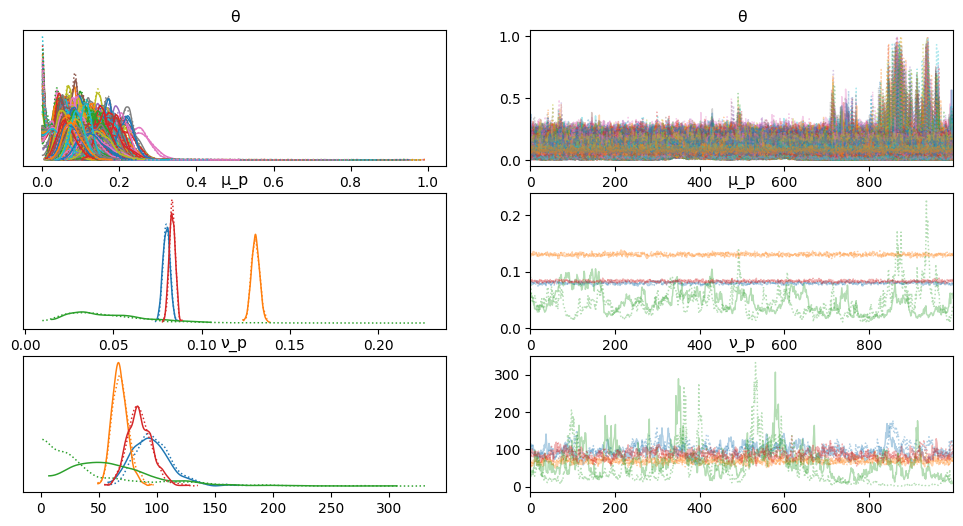

In [13]:
az.plot_trace(idata_sccr)

In [14]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.003 1.002 ... 1.001 1.001 1.002
    μ_p      (pos) float64 32B 1.003 1.005 1.073 1.002
    ν_p      (pos) float64 32B 1.007 1.003 1.123 1.008

it looks pretty much the same.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Text(0.5, 1.0, 'MF (DOOM) mean')

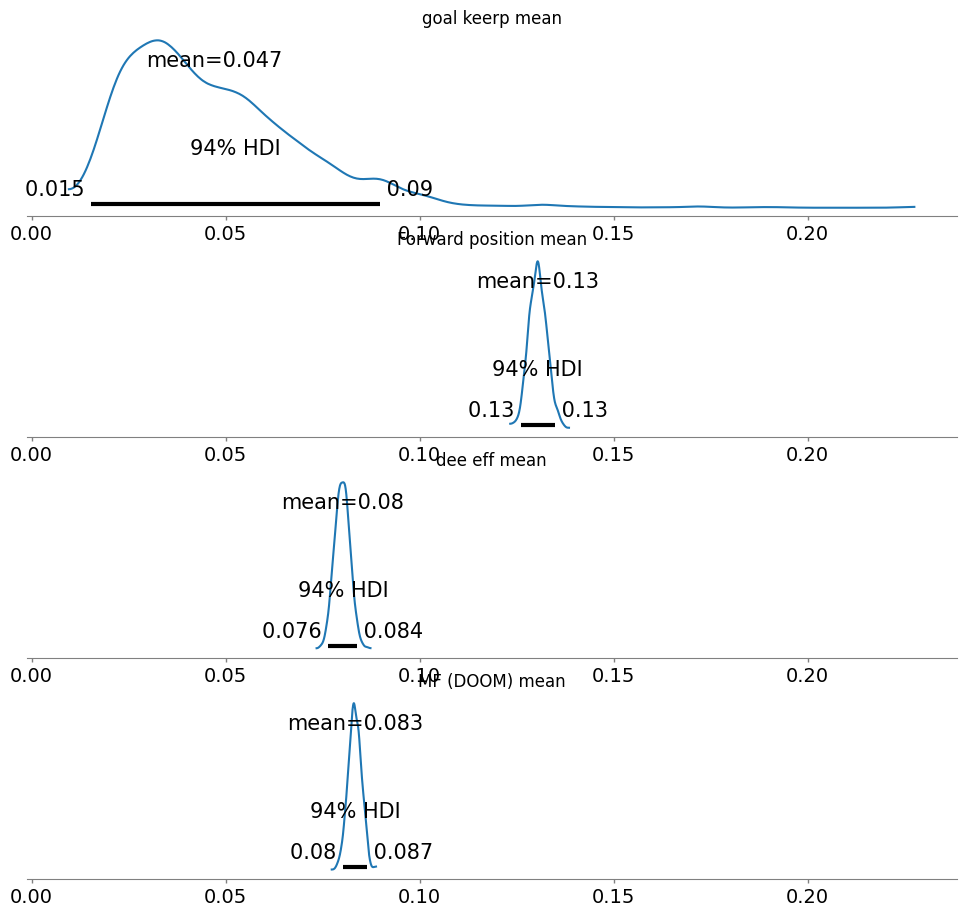

In [15]:
#preps a plot object to have three seperate plots, all with the same x axis
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

az.plot_posterior(idata_sccr.posterior.sel(pos="GK"), var_names='μ_p', ax=ax[0])
ax[0].set_title("goal keerp mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title("Forward position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[2])
ax[2].set_title("dee eff mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[3])
ax[3].set_title("MF (DOOM) mean")

they are basically identical

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [67]:
sccr_data_2_2sccr_2data=sccr_data.query('position!="GK"')
sccr_data_2_2sccr_2data.position = sccr_data_2_2sccr_2data.position.cat.remove_unused_categories()
sccr_data_2_2sccr_2data.position.cat.categories

/tmp/ipython-input-3445493900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sccr_data_2_2sccr_2data.position=sccr_data_2_2sccr_2data.position.cat.remove_unused_categories()


Index(['DF', 'FW', 'MF'], dtype='object')

In [63]:
pos_idx2_2pos_2idx = sccr_data_2_2sccr_2data.position.cat.codes.values
#print(pos_idx2_2pos_2idx)
#an array of the four strings that represent position
pos_codes2_2pos_2codes = sccr_data_2_2sccr_2data.position.cat.categories
#print(pos_codes2_2pos_2codes)
#puts coords in a dict, so pymc can read them
sccr_coords2_2sccr_2coords = {"pos": pos_codes2_2pos_2codes}


{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}

In [ ]:
with pm.Model(coords = sccr_coords2_2sccr_2coords) as sccr_model3:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx2_2pos_2idx], nu = ν_p[pos_idx2_2pos_2idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_2_2sccr_2data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_2_2sccr_2data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr2 = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

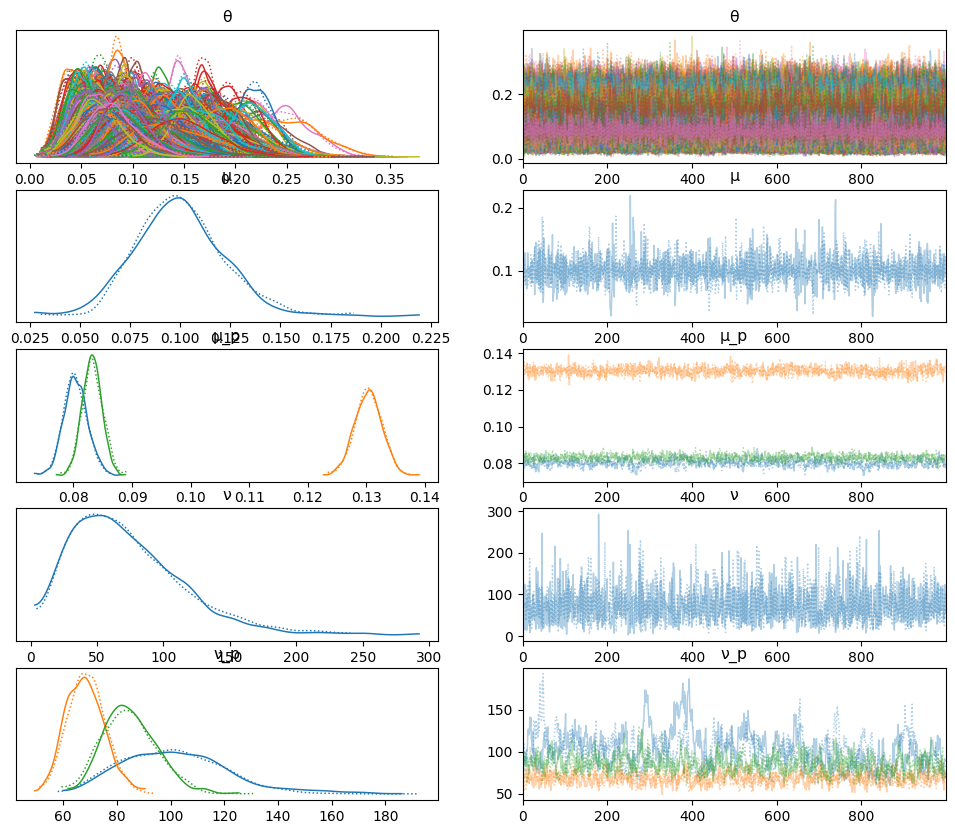

In [62]:
az.plot_trace(idata_sccr2)

Text(0.5, 1.0, 'MF (DOOM) mean')

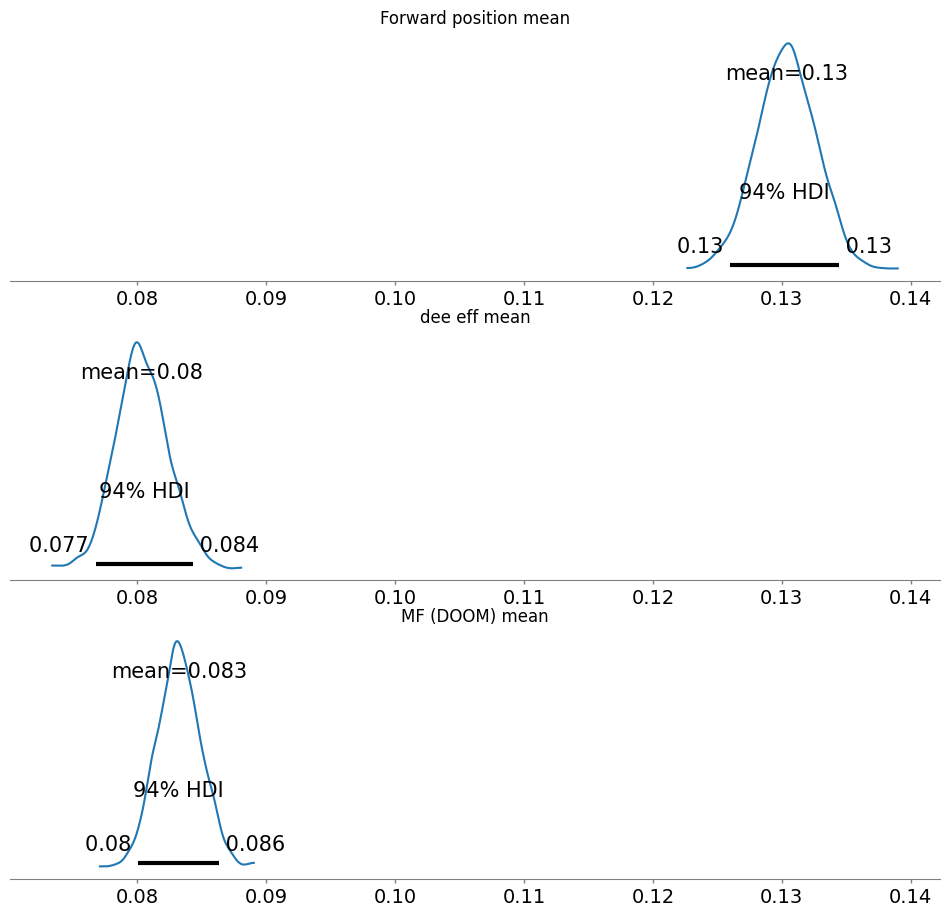

In [73]:
#preps a plot object to have three seperate plots, all with the same x axis
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)



az.plot_posterior(idata_sccr2.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[0])
ax[0].set_title("Forward position mean")

az.plot_posterior(idata_sccr2.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[1])
ax[1].set_title("dee eff mean")

az.plot_posterior(idata_sccr2.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[2])
ax[2].set_title("MF (DOOM) mean")

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

In [70]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.003 1.002 ... 1.001 1.001 1.002
    μ_p      (pos) float64 32B 1.003 1.005 1.073 1.002
    ν_p      (pos) float64 32B 1.007 1.003 1.123 1.008

In [71]:
az.rhat(idata_sccr2)


<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.005 1.001 1.003 ... 1.004 1.0 1.002
    μ        float64 8B 0.9999
    μ_p      (pos) float64 24B 1.002 1.001 1.001
    ν        float64 8B 0.9999
    ν_p      (pos) float64 24B 1.054 1.001 1.009

the rhat for the one without golakkeepr was 4 secodns while thile other one was 5 so it was 20 perncet faster. The same is true for the plot trace but with minutes instead of seconds.

By dropping GK from the data set we loose data about goalkeepers, however because that data kinda sucks for the thing we are looking at it results in us getting a faster runtime and more accurate data. With heirarchal models, since they use the other catageroies as well, not having bad data makes them more accurate. thats pretty cool 👍😎👍